# Learning a spatial transforation between images using OT

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

from utils import plot_maxproj, pixel_dist_3d

In [3]:
np.random.seed(1993)

## The problem

Let $A$ and $B$ be images related by a parametrized spatial transform $T_{\theta}$, such that $B = T_{\theta}(A)$. Given $A$ and $B$, how can we recover $\theta$?

### Notation

- Let $X$ ($n$ * $d$) be the set of pixel locations in $d$-dimensional space, and let $X_i$ be the $i^{th}$ pixel location
- Let $a$ and $b$ ($n$ * 1) be pixel intensities for the images $A$ and $B$ (e.g. $a_i$ is the intensity at location $X_i$ in image $A$)

### Example

For this example, we will make $T$ an affine transform, where $T(x) = \alpha + \beta x$, and $\theta = \{\alpha, \beta\}$

#### Parameters

In [4]:
# Image size
img_shape = (50, 25, 5)
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

#### Create $A$: Sum of three truncated Gaussians

In [5]:
# 'Cells' are truncated Gaussians
th = 1e-4
cov = 3 * np.eye(3)
mu_1 = np.array([20, 10, 3])
mu_2 = np.array([10, 15, 3])
mu_3 = np.array([10, 5, 3])
cell_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
cell_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)
cell_3 = multivariate_normal.pdf(grid, mu_3, cov).reshape(img_shape)
cell_1[cell_1 < th] = 0 
cell_2[cell_2 < th] = 0 
cell_3[cell_3 < th] = 0 

# First image contains two 'cells'
A = cell_1  + cell_2 + cell_3

#### Choose ground-truth $\alpha$ and $\beta$ and use them to create $B$

In [6]:
# Affine transformation to apply to source image
#theta = np.pi / 16
#beta = np.array([
#    [np.cos(theta), -np.sin(theta), 0], 
#    [np.sin(theta),  np.cos(theta), 0],
#    [0,              0,             1]
#])
beta = np.eye(3, 3)
alpha = np.array([12, 5, 0])
#alpha = np.array([0, 0, 0])

# Create B by applying T to A (requires inverse of T)
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha
B = affine_transform(A, inv_beta, inv_alpha)

#### Add floor value and noise (optional)

In [7]:
# Parameters
floor_val = 1e-7
noise_level = 0

# Noise is absolute value of Gaussian
noise_1 = np.abs(np.random.randn(*img_shape)) * noise_level
noise_2 = np.abs(np.random.randn(*img_shape)) * noise_level

A = A + floor_val + noise_1
B = B + floor_val + noise_2

image shape: (50, 25, 5)
num. pixels: 6250
alpha:
[12  5  0]
beta:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


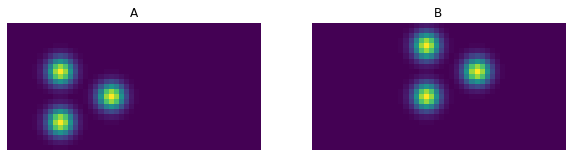

In [8]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(A)
plt.title('A')
plt.axis('off');

plt.subplot(122)
plot_maxproj(B)
plt.title('B')
plt.axis('off');

print(f'image shape: {img_shape}')
print(f'num. pixels: {n_pixels}')
print('alpha:')
print(alpha)
print('beta:')
print(beta)

## Proposed solution: Use optimal transport plan to find $\theta$


### Example

#### Compute optimal transport plan between frames

In [16]:
# Entropic regularization parameter
reg = 1e-3

# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.sinkhorn(A.flatten(), B.flatten(), M, reg, verbose=False)

### Compute values used for all regression methods

#### Minimize cost function to estimate $\alpha$ and $\beta$

In [17]:
# Threshold to apply to P matrix (this speeds up computation)
p_th = 1e-7

# Pixel locations
X = grid.reshape(-1, 3)

# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P > p_th)
pts_a = X[a_idx]
pts_b = X[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('alpha (true):')
print(alpha)

print('beta (est):')
print(beta_est)
print('beta (true):')
print(beta)

alpha (est):
[0.02913729 0.13066218 0.04586527]
alpha (true):
[12  5  0]
beta (est):
[[ 9.98665955e-01  3.87692501e-04 -2.49173471e-05]
 [ 3.19637492e-04  9.88683721e-01  7.28882264e-04]
 [ 2.03516112e-05  7.87162013e-05  9.77228694e-01]]
beta (true):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


#### Use estimated transform to reconstruct $B$ from $A$

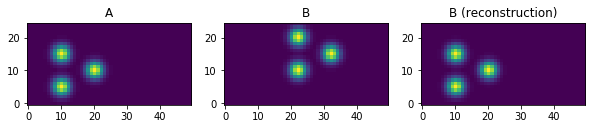

In [18]:
# Reconstruct A from B
inv_beta_est = np.linalg.inv(beta_est)
inv_alpha_est = -inv_beta_est @ alpha_est
B_recon = affine_transform(A, inv_beta_est, inv_alpha_est)

plt.figure(figsize=(10, 10))

plt.subplot(131)
plot_maxproj(A)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(B)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(B_recon)
plt.title('B (reconstruction)');